In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Change directory to your working directory
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/NLP Project/"

os.chdir(DATA_DIR)
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/NLP Project'

In [ ]:
%pip install transformers datasets torch scikit-learn

In [ ]:
import torch
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [ ]:
df = pd.read_csv("final_dataset.csv")  # Ensure dataset has 'text' and 'label' columns
df = df.dropna()  # Drop missing values if any
df = df.rename(columns={"type": "label"})  # Renames "type" column to "label"

# Select only the two required columns (e.g., "text" and "label")
selected_columns = ["text", "label"]
df_subset = df[selected_columns]

# Randomly select 500 rows with a fixed seed for reproducibility
df = df_subset.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the new DataFrame
print(df.head())

                                                text    label
0  madam secretary please close voting results ey...   spoken
1      ugh hopefully asus ppl dont randomly reformat  written
2  wanted wish happy new year wanted talk legal a...  written
3                          okay ive seen pick friday  written
4  like express sincere congratulations mr gurira...   spoken


In [ ]:
id2label = {0: "written", 1: "spoken"}
label2id = {"written": 0, "spoken": 1}

In [ ]:
df["label"] = df["label"].map(label2id)

In [ ]:
dataset = Dataset.from_pandas(df)
# Split into train/test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

In [ ]:
train_dataset[0]

{'text': 'presolar grains meteorites remnants early times solar system review provides introduction presolar grains preserved stardust interstellar molecular cloud solar system formed found primitive meteorites describe search presolar components currently known presolar mineral populations chemical isotopic characteristics grains dustforming stars identify grains probable stellar sources keywords presolar grains interstellar dust asymptotic giant branch agb stars novae supernovae nucleosynthesis isotopic ratios meteorites introduction history solar system started gravitational collapse interstellar molecular cloud laden gas dust supplied dying stars dust cloud topic review small fraction dust escaped destruction many processes occurred molecular cloud collapse ga ago define presolar grains stardust formed stellar outflows ejecta remained intact throughout journey solar system preserved meteorites survival presence genuine stardust meteorites expected early years meteorite studies s s 

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)


In [ ]:

# Apply tokenization
train_dataset = train_dataset.map(preprocess_function, batched=True)
eval_dataset = eval_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2268 [00:00<?, ? examples/s]

Map:   0%|          | 0/568 [00:00<?, ? examples/s]

In [ ]:
train_dataset['label'][0]

0

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
!pip install evaluate

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

BATCH_SIZE = 16
EPOCHS = 5
batches_per_epoch = len(train_dataset) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * EPOCHS)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    eval_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

In [ ]:
import tensorflow as tf

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [ ]:
!pip install wandb

In [ ]:
! wandb login
# API KEY = 8544b034b0ba783804d4ba2d8bcdbeb3fe2de75c

wandb: Currently logged in as: shivanipuli (shivanipuli-university-of-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
from transformers import TrainingArguments

# ✅ Initialize W&B
wandb.init(project="final_bert_models")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# ✅ Modify Training Arguments to enable logging
training_args = TrainingArguments(
    output_dir="./final_bert_classifier",
    run_name="final_bert_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,  # Log every 10 steps
    report_to="wandb",  # ✅ Enables logging to W&B
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    load_best_model_at_end=True,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-59-eb4c7ea1fbf5>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
"""
trainer.train()
eval_results = trainer.evaluate()
print(eval_results)
trainer.save_model("./bert_final_model")  # ✅ Saves the model
tokenizer.save_pretrained("./bert_final_model")  # ✅ Saves tokenizer
trainer.save_state()  # ✅ Saves optimizer, scheduler, and Trainer state
"""

'\ntrainer.train()\neval_results = trainer.evaluate()\nprint(eval_results)\ntrainer.save_model("./bert_final_model")  # ✅ Saves the model\ntokenizer.save_pretrained("./bert_final_model")  # ✅ Saves tokenizer\ntrainer.save_state()  # ✅ Saves optimizer, scheduler, and Trainer state\n'

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "bert_final_model"
# if not os.path.exists(model_path):
#     print("MODEL PATH DNE")
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: bert_final_model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.6655799150466919, 'eval_model_preparation_time': 0.0029, 'eval_accuracy': 0.5633802816901409, 'eval_precision': 0.7557101043204163, 'eval_recall': 0.5633802816901409, 'eval_f1': 0.4151958776373165, 'eval_runtime': 18.5431, 'eval_samples_per_second': 30.631, 'eval_steps_per_second': 1.941}


In [ ]:
import torch

text = "I think this might be a good idea."
inputs = tokenizer(text, return_tensors="pt")

model.eval()
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
print(f"Predicted Label: {id2label[predicted_class_id]}")


Predicted Label: spoken


In [ ]:
text = "The contextual evidence relating to the study (often relating to academics) indicates otherwise."
inputs = tokenizer(text, return_tensors="pt")

model.eval()
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
print(f"Predicted Label: {id2label[predicted_class_id]}")

Predicted Label: written


## SHAP Explainer ##

In [ ]:
import torch
import shap
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import shap
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "./bert_finetuned_spoken_vs_written"
model2 = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer2 = AutoTokenizer.from_pretrained(model_path)

model2.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import numpy as np

def predict_probabilities(texts):
    inputs = tokenizer2(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        logits = model2(**inputs).logits

    probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()
    return probabilities


In [ ]:
sample_text = "Uh, so, like, I think we should probably head out now."
explainer = shap.Explainer(lambda x: predict_probabilities(x), masker=shap.maskers.Text(tokenizer2))

In [ ]:
shap_values = explainer(sample_text)
shap.text_plot(shap_values)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
import shap
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "./bert_finetuned_spoken_vs_written"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.eval()

def predictor(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()
    return probabilities


Provided model function fails when applied to the provided data set.


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
# sample_text = ["Uh, so, like, I think we should probably head out now."]
baseline_texts = np.array(train_dataset["text"][:10], dtype=str).reshape(-1, 1)  # Explicitly set dtype=object for SHAP

explainer = shap.KernelExplainer(predictor, np.column_stack((train_dataset["text"], train_dataset["label"])))  # Dummy data for SHAP baseline
shap_values = explainer.shap_values(eval_dataset)
shap.text_plot(shap_values)
colour_test = pd.DataFrame(X_test_sample.todense())

Provided model function fails when applied to the provided data set.


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
prediciton = predictor(sample_text)
prediciton

array([[0.00973942, 0.99026054]], dtype=float32)

In [ ]:
import shap
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "./bert_finetuned_spoken_vs_written"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.eval()

def predictor(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()
    return probabilities

sample_text = ["Uh, so, like, I think we should probably head out now."]

explainer = shap.KernelExplainer(predictor, [0]*512)
shap_values = explainer.shap_values(sample_text, nsamples=50)

shap.text_plot(shap_values)

TypeError: Unknown type passed as data object: <class 'list'>

## Load Test Dataset

In [ ]:
""" ONLY RAN ONCE
from datasets import load_dataset, Dataset
import pandas as pd
test_df = pd.read_csv('test_dataset.csv')

# Define mapping of sources to "spoken" or "written"
source_to_type = {
    'sms': 'written',
    'podcasts': 'spoken',
    'telephone_convos': 'spoken',
    'khan_academy': 'spoken',
    'business_meetings': 'spoken',
    'enron_emails': 'written',
    'textbooks': 'written',
    'medium': 'written',
    'un_debates': 'spoken',
    'un_corpus': 'written'
}

# Create the "type" column based on the mapping
test_df['type'] = test_df['source'].map(source_to_type)
test_df.reset_index(drop=True, inplace=True)
test_df.to_csv('test_dataset.csv', index=False)
"""

In [ ]:
import pandas as pd

test_df = pd.read_csv('test_dataset.csv')
test_df

,text,source,formality,type
0,"\nSir, it is indeed a great pleasure for me, ...",un_debates,formal,spoken
1,1. Have a peek at our guidelines:\n\nWhat to a...,medium,semiformal,written
2,"{D Well, } that, - /yeah /{C but } <bird_squa...",telephone_convos,informal,spoken
3,XV,un_corpus,formal,written
4,"“Your subconscious mind works continuously, wh...",medium,semiformal,written
...,...,...,...,...
965,WEBVTT\nKind: captions\nLanguage: en\n\n00:00:...,khan_academy,educational,spoken
966,Summary: Workers' ire over 401(k) plans is und...,enron_emails,formal,written
967,"It is a pleasure for me, on behalf of the Gove...",un_debates,formal,spoken
968,Okay. Thank you. We'll going now to item 19.\...,business_meetings,formal,spoken


In [ ]:
print(set(test_df['source'].unique()))

{'podcasts', 'business_meetings', 'un_corpus', 'un_debates', 'telephone_convos', 'textbooks', 'enron_emails', 'khan_academy', 'medium', 'sms'}


In [ ]:
import pandas as pd

test_df = test_df.groupby('source', group_keys=False).apply(lambda x: x.sample(n=min(len(x),30), random_state=42))
test_df = test_df.reset_index(drop=True)
test_df


<ipython-input-66-87645cd40557>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby('source', group_keys=False).apply(lambda x: x.sample(n=min(len(x),30), random_state=42))


,text,source,formality,type
0,I'm sorry. Can you repeat that number?\n Item...,business_meetings,formal,spoken
1,Thank you so much. Thank you. Appreciate that...,business_meetings,formal,spoken
2,"Thank you. So just as a reminder, we have one...",business_meetings,formal,spoken
3,Thank you. Next is 22.\n Report from Developm...,business_meetings,formal,spoken
4,Thinking that we're doing the two commission ...,business_meetings,formal,spoken
...,...,...,...,...
285,I \nwould like to join previous speakers in co...,un_debates,formal,spoken
286,﻿Allow me at the outset to extend my congratul...,un_debates,formal,spoken
287,"I should like, on behalf of the Malawi delegat...",un_debates,formal,spoken
288,141.\t As my opening remark I should like as m...,un_debates,formal,spoken


In [ ]:
import pandas as pd

category_counts = test_df['source'].value_counts()

category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['source', 'count']

print(category_counts_df)
""" Since podcasts are significantly longer, we used a smaller dataset"""

              source  count
0  business_meetings     30
1       enron_emails     30
2       khan_academy     30
3             medium     30
4                sms     30
5   telephone_convos     30
6          un_corpus     30
7          textbooks     30
8         un_debates     30
9           podcasts     20


' Since podcasts are significantly longer, we used a smaller dataset'

In [ ]:
test_df = test_df.sample(frac=1, random_state=42)

In [ ]:
test_df['label'] = test_df['type'].map(label2id)

In [ ]:
## Preprocessing text
import nltk
from nltk.corpus import stopwords
import string
import re

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def preprocess_all_text(text):
    # Handle NoneType objects
    if text is None:
        return None

    # Remove code?? and HTML tags
    text = re.sub(r'<[^>]+>', '', text)  # HTML tags
    text = re.sub(r'```.*?```', '', text, flags=re.DOTALL)  # Removes code blocks (```code```)

    text = text.lower()
    #REMOVE URLS AND LINKS
    text = re.sub(r'http\S+|www\.\S+|\S+\.(com|org|net|io|co|uk|gov|edu)\S*', '', text)
    # Remove everything that is not a letter or space
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #Remove stop words
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    #remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Return None if the text is empty after preprocessing
    if not text:
        return None

    return text

test_df["processed"] = test_df["text"].apply(preprocess_all_text)
test_df = test_df.dropna(subset=["processed"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
test_df

,text,source,formality,type,label,processed
84,WEBVTT\nKind: captions\nLanguage: en\n\n00:00:...,khan_academy,educational,spoken,1,webvtt kind captions language en waves splashi...
258,"(a) Subject to regulations 12.1, 12.2, 12.3, 1...",un_corpus,formal,written,0,subject regulations rules may amended secretar...
45,Enron is trying to improve disclosure to inves...,enron_emails,formal,written,0,enron trying improve disclosure investors deci...
175,Watch my Dallas Cowboys. /I watched them to h...,telephone_convos,informal,spoken,1,watch dallas cowboys watched halftime left c l...
143,His bday real is in april .\n,sms,informal,written,0,bday real april
...,...,...,...,...,...,...
188,-- sitting in the back of the bus and everythi...,telephone_convos,informal,spoken,1,sitting back bus everything
71,WEBVTT\nKind: captions\nLanguage: en\n\n00:00:...,khan_academy,educational,spoken,1,webvtt kind captions language en told standard...
106,Brain by Gordon Johnson\n\nLooking back at the...,medium,semiformal,written,0,brain gordon johnson looking back explainable ...
270,1.\t The delegation of Rwanda would like to a...,un_debates,formal,spoken,1,delegation rwanda would like add voice delegat...


In [ ]:
import torch
import numpy as np
import pandas as pd

# Ensure model is in evaluation mode
model.eval()

# Initialize storage for embeddings and predictions
embeddings_list = []
predicted_labels_list = []

# Process data in batches
for i in range(0, len(test_df), BATCH_SIZE):
    batch_texts = test_df['processed'].iloc[i:min(i+BATCH_SIZE, len(test_df))].tolist()

    # Tokenize entire batch at once
    inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

        # Extract predictions
        predicted_labels = outputs.logits.argmax(dim=1).tolist()

        # Extract CLS token embeddings
        batch_embeddings = outputs.hidden_states[-1][:, 0, :].numpy()

    # Store results
    predicted_labels_list.extend(predicted_labels)
    embeddings_list.extend(batch_embeddings)

test_df["predicted_label"] = predicted_labels_list
test_df["embeddings"] = embeddings_list


In [ ]:
test_df

,text,source,formality,type,label,processed,predicted_label,embeddings
84,WEBVTT\nKind: captions\nLanguage: en\n\n00:00:...,khan_academy,educational,spoken,1,webvtt kind captions language en waves splashi...,0,"[-0.7184008, -0.48065034, 0.12264228, 0.349379..."
258,"(a) Subject to regulations 12.1, 12.2, 12.3, 1...",un_corpus,formal,written,0,subject regulations rules may amended secretar...,0,"[-0.41473648, -0.08719737, 1.1458771, -0.29816..."
45,Enron is trying to improve disclosure to inves...,enron_emails,formal,written,0,enron trying improve disclosure investors deci...,0,"[-0.32571754, -0.16789421, 0.92729825, -0.2179..."
175,Watch my Dallas Cowboys. /I watched them to h...,telephone_convos,informal,spoken,1,watch dallas cowboys watched halftime left c l...,0,"[-0.52898616, -0.22470865, 0.7687908, 0.065159..."
143,His bday real is in april .\n,sms,informal,written,0,bday real april,0,"[-0.21042937, -0.35174477, 1.0567957, -0.30356..."
...,...,...,...,...,...,...,...,...
188,-- sitting in the back of the bus and everythi...,telephone_convos,informal,spoken,1,sitting back bus everything,0,"[-0.32288364, -0.17553015, 1.0337489, -0.14936..."
71,WEBVTT\nKind: captions\nLanguage: en\n\n00:00:...,khan_academy,educational,spoken,1,webvtt kind captions language en told standard...,1,"[-0.20848365, 0.23014648, -1.1026409, -0.53659..."
106,Brain by Gordon Johnson\n\nLooking back at the...,medium,semiformal,written,0,brain gordon johnson looking back explainable ...,0,"[-0.34092212, -0.088110946, 0.96104723, -0.262..."
270,1.\t The delegation of Rwanda would like to a...,un_debates,formal,spoken,1,delegation rwanda would like add voice delegat...,1,"[-0.25242466, -0.04417215, -1.1254172, -0.6708..."


In [ ]:
test_df.to_csv('test_df_with_embeddings.csv', index=False)

## Mislabeled Data Analysis

In [ ]:
import pandas as pd

# Ensure all sources are present
all_sources = test_df["source"].unique()

misclassified_df = test_df[test_df["label"] != test_df["predicted_label"]]

result = misclassified_df.groupby("source")["label"].value_counts().unstack(fill_value=0)

result = result.reindex(columns=[0, 1], fill_value=0)

result = result.reindex(all_sources, fill_value=0)

print("Misclasiffied text by source")
result.columns = ["written", "spoken"]
result = result.reset_index()

result


Misclasiffied text by source


ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

In [ ]:
formalities = test_df["formality"].unique()
formalities

array(['educational', 'formal', 'informal', 'semiformal'], dtype=object)

In [ ]:
import pandas as pd

formalities = test_df["formality"].unique()
misclassified_df = test_df[test_df["label"] != test_df["predicted_label"]]
misclass_counts = misclassified_df.groupby("formality")["label"].value_counts().unstack(fill_value=0)
misclass_counts = misclass_counts.reindex(columns=[0, 1], fill_value=0)
misclass_counts = misclass_counts.reindex(formalities, fill_value=0)
result = misclass_counts.reset_index()
result.columns = ["Formality", "Written", "Spoken"]
result[["Spoken", "Written"]] = (1 - (result[["Spoken", "Written"]] / 30)).round(2)
result = result.sort_values(by="Formality")
print("Accuracy Matrix")
result

Accuracy Matrix


,Formality,Written,Spoken
0,educational,1.00,0.90
1,formal,1.00,0.97
2,informal,0.93,0.87
3,semiformal,1.00,1.00


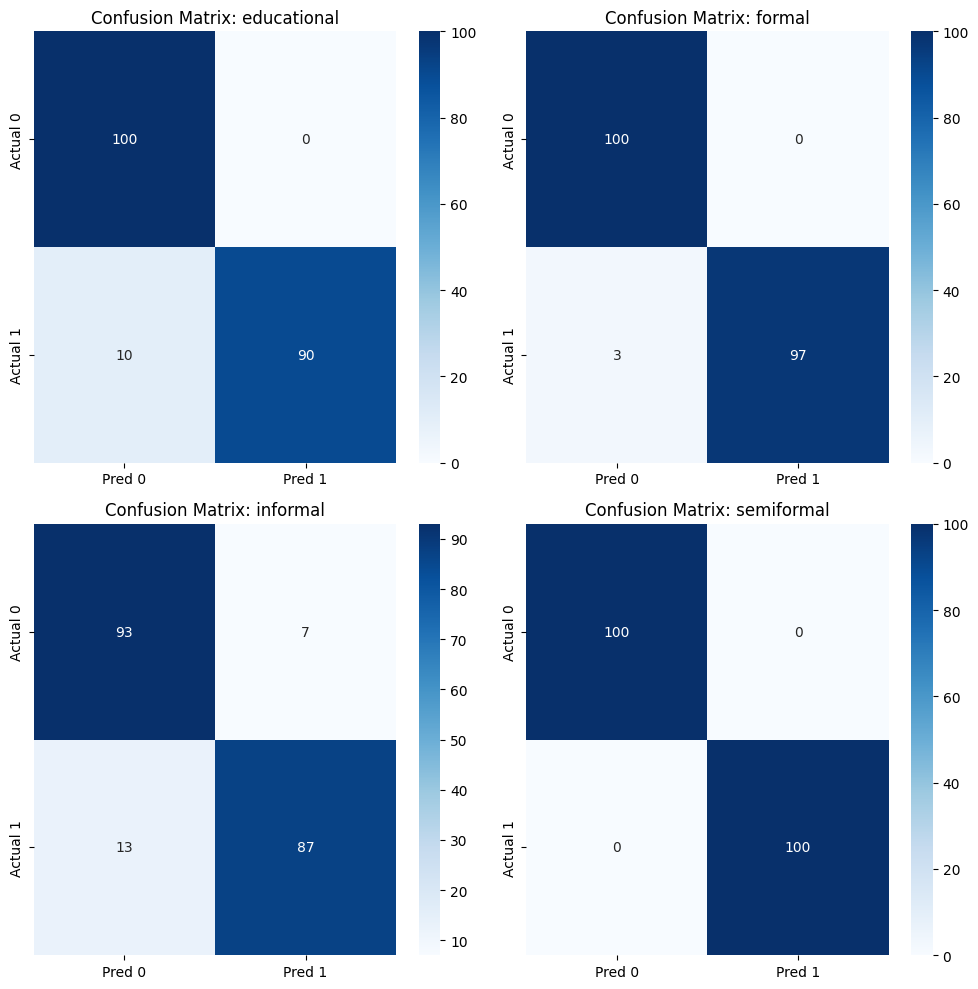

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

total_samples = 100

#convert accuracy to confusion matrix values
def compute_confusion_matrix(accuracy_written, accuracy_spoken):
    TP = int(accuracy_spoken * total_samples)
    TN = int(accuracy_written * total_samples)
    FN = total_samples - TP
    FP = total_samples - TN
    return np.array([[TN, FP], [FN, TP]])

#create confusion matrices for each formality level
conf_matrices = {}
for _, row in result.iterrows():
    formality = row["Formality"]
    conf_matrices[formality] = compute_confusion_matrix(row["Written"], row["Spoken"])

#plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, (formality, matrix) in enumerate(conf_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"], ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix: {formality}")

plt.tight_layout()
plt.show()


TypeError: unhashable type: 'numpy.ndarray'

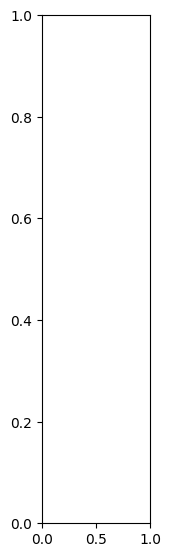

In [ ]:
import pandas as pd
import shap
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

data = {
    'text': ["This is annoying isn't it"]
}
df = pd.DataFrame(data)
model.eval()

def tokenize(texts):
    texts = [str(text) for text in texts]
    return tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

def predict(texts):
    inputs = tokenize(texts)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    return probabilities.numpy()

texts_to_explain = [str(text) for text in df['text'].tolist()]
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict, masker)
shap_values = explainer(texts_to_explain)

shap.plots.text(shap_values[0])
shap.summary_plot(shap_values, texts_to_explain, feature_names=tokenizer.get_vocab())


import matplotlib.pyplot as plt  # Import matplotlib for saving the plot

plt.savefig("shap_plot.png", bbox_inches="tight", dpi=300)  # Save as PNG


## TSNE Graphical Analysis

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(np.vstack(test_df['embeddings'].values))


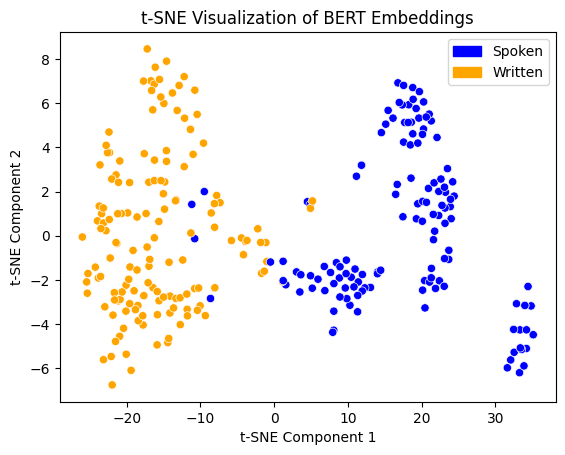

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=test_df['type'], palette=["blue", "orange"])
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of BERT Embeddings")
spoken_patch = mpatches.Patch(color="blue", label="Spoken")
written_patch = mpatches.Patch(color="orange", label="Written")

plt.legend(handles=[spoken_patch, written_patch])
plt.show()

In [ ]:
print(id2label[train_dataset[0]["label"]], train_dataset[0]["text"])

written 9. the special rapporteur has continued to place particular emphasis on cooperation with all bodies of the united nations and other regional intergovernmental human rights organizations.


In [ ]:
import pandas as pd

selected_columns = ["text", "label", "source"]
df_subset = df[selected_columns]

df_sampled = df_subset.sample(n=500, random_state=42)

df_sampled = df_sampled.reset_index(drop=True)

print(df_sampled.head())
df_sampled["label"] = df_sampled["label"].map(label2id)
dataset = Dataset.from_pandas(df_sampled)
# Split into train/test sets
dataset = dataset.train_test_split(test_size=0.2)
eval_dataset = dataset["test"]

                                                text    label  \
0  would you please provide me with some examples...  written   
1  book title sealed by a kiss author ava gray de...  written   
2  convention on the prohibition of the developme...  written   
3  motion carries. okay. thank you, madam. item 1...   spoken   
4  the voices of indigenous peoples must be heard...  written   

              source  
0       enron_emails  
1          textbooks  
2          un_corpus  
3  business_meetings  
4          un_corpus  


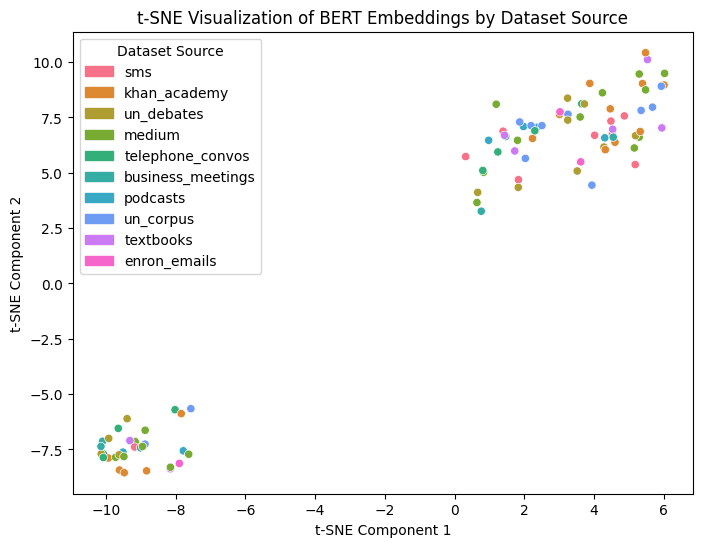

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_sources = set(eval_dataset["source"]) 
palette = sns.color_palette("husl", len(unique_sources))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=eval_dataset["source"], palette=palette)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of BERT Embeddings by Dataset Source")

legend_patches = [mpatches.Patch(color=palette[i], label=source) for i, source in enumerate(unique_sources)]
plt.legend(handles=legend_patches, title="Dataset Source")
plt.show()

## Miscallaneous Unnecessary

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sample_text = "has continued to place particular emphasis on cooperation with all bodies of the united nations"
inputs = tokenizer(sample_text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attention = outputs.attentions[-1][0].numpy()  

tokens = tokens[1:10]  
#attention = attention_matrix[1:10, 1:10]  # Slice matrix to match


head_index = 9  
attention_matrix = attention[head_index] 

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="coolwarm")
plt.xlabel("Attention Given To")
plt.ylabel("Attention From")
plt.title(f"BERT Attention Heatmap (Head {head_index})")
plt.xticks(rotation=45)
plt.show()


Token indices sequence length is longer than the specified maximum sequence length for this model (39374 > 512). Running this sequence through the model will result in indexing errors


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).